In [165]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from astropy.visualization import AsinhStretch, AsymmetricPercentileInterval
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
from skimage.transform import rescale, rotate
from scipy.stats import norm as gauss

# Mock observations - fields

1. Create a **field** from a range of galaxies, similar to [GZ images here](https://www.illustris-project.org/galaxy_obs/)
    * Projected to different redshifts; different stellar masses
    * Can impose galaxies on top of each other to create "merger-like" images
    * Add stars
2. Convolve to different seeing & image depth

***

**Things we want to vary**

1. Field size: small snapshot or large field
    * CANDELS field: about 7 arcmin across
    * Illustris synthetic field: 2.8 arcmin across
    * VELA synthetic field: 1 arcmin across
    * HST field of view: 162 arcsec across
    * Small snapshot: 50 arcsec across<br><br>
    
2. Redshift of the galaxy
    * Default: 50,000 kpc away from camera, z = 0
    * Want to move them to different redshifts; apply surface brightness dimming
    * Sample from expected number density of galaxies per redshift<br><br>

3. Number of galaxies
    * Sample from number density / z
    * Clusters vs non-clusters?
    
## Field parameters

1. Random size in pixels between `IMGSIZE_MIN` and `IMGSIZE_MAX`
    * Captures small snapshots and somewhat large snapshots at SDSS resolution
    * Not CANDELS-like but easier to train; CANDELS-like images can be split <br><br>
    
2. Random number of galaxies in image
    * $f \times L_{img}$ 
    * $f$ is a random number between `GAL_FRAC` $\pm$ `D_GAL_FRAC` <br><br>
    
3. Sample all galaxies from all redshifts, masses, camera angles randomly. 
    * This isn't really realistic; but we train on mergers and weird galaxies more if we have more nearby/overlapping/massive galaxies.
    * Redshift is picked from a *gaussian* distribution with `Z_MEAN` and `Z_SD`
    * Rotate galaxies & their segmaps 
    * Place anywhere on the image; the galaxy edges may be cut-off
    
4. Illustris simulations do not go to 0 SB at the edge of the snapshot, so we want to flood the image with some noise to smooth over the box edges
    * Some galaxies are really bright at box edges
    * Check average SB at edges. If it's higher than `BG_THRESHOLD` then don't use this galaxy


In [345]:
# Path where `subhaloes` folder containing subhaloes and `fields` folder are loacted
path         = "data" 

# Limits to generate random redshift, rotation angle and position within field
RNG_LIMITS   = {
    
    "IMGSIZE_MIN"  : 300,   # Single Illustris snapshot is a 256 x 256 box
    "IMGSIZE_MAX"  : 800,

    "GAL_FRAC"     : 0.05,  # Smallest field will have 9 galaxies
    "D_GAL_FRAC"   : 0.02,  # Largest field will have 56 galaxies

    "Z0"           : 0.116, # All galaxies are observed from 50 Mpc or z0 = 0.116
    "Z_MEAN"       : 0.7,   # Most galaxies would be small
    "Z_SD"         : 0.4,   # A couple of galaxies nearby

    "BG_THRESHOLD" : 27,    # mag/arcsec2. Segmap threshold is 26, so this is 10 times fainter 

    # If True, the entire galaxy must fit onto the field image. Otherwise, some parts can be cut off.
    "GALAXIES_MUST_FIT" : False
}


**Example galaxy to test transformations on**

In [147]:
EXAMPLE = True

if EXAMPLE:
    test_id = "416531_1"
    file    = fits.open(f"{path}/subhaloes/{test_id}.fits")
    img     = np.array(file[0].data, dtype=np.float64)
    segmap  = file[1].data 
    file.close()

## Transforming a galaxy

We do three transformations:

1. Move to a redshift: `move_to_z`
2. Rotate: `rotate_galaxy` 
3. Rescale size to match the box size before adding it to the field: `project_to_field`

### Move to a redshift

All galaxies were observed at distance 50 Mpc or $z_0 \approx 0.116$.

We want to move a galaxy to a different redshift but keep the pixel scale the same.

$$\theta_{px} = \frac{D_{px}}{d}$$

where $d$ is the distance, $D_{px}$ is the resolution in kpc and $\theta_{px}$ is the resolution in arcseconds. We just need to re-sample the image by $d_1/d_0$ effectively changing $D_{px}$

In [148]:
def move_to_z(img, segmap, z, z0):
    """Rescale the galaxy image and segmentation map by moving it to a further redshift z. No cosmological dimming is applied.
    INPUTS:
        img:    np.ndarray with galaxy iamge
        segmap: integer np.ndarray with segmentation map
        z:      redshift to move the galaxy to
        z0:     original redshift of the galaxy
        
    OUTPUTS:
        newimg: rescaled image, dimmed by a factor (r0/r)^2
        newmap: rescaled segmentation map
    """
    
    # Calculate the distances at original and new redshits
    r0       = cosmo.comoving_distance(z0).value
    r1       = cosmo.comoving_distance(z).value
    ratio    = (r0 / r1) 
    
    # Simple 1/r^2 flux dimming, no cosmological dimming
    newimg   = img * ratio**2
    
    # Change image size to reflect larger distance, no cosmological effects
    newimg   = rescale(newimg, ratio, anti_aliasing=True)
    newmap   = rescale(segmap, ratio, preserve_range=True, anti_aliasing=False)
        
    return newimg, newmap

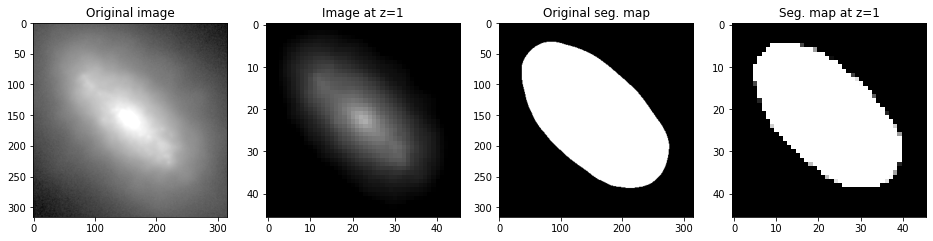

In [149]:
if EXAMPLE:
    
    img_z, map_z = move_to_z(img, segmap, 1, Z0)
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(-2.5*np.log10(img),     cmap="gray_r",  vmin=20, vmax=30); axs[0].set_title("Original image")
    axs[1].imshow(-2.5*np.log10(img_z),   cmap="gray_r",  vmin=20, vmax=30); axs[1].set_title("Image at z=1")
    axs[2].imshow(segmap,                 cmap="gray"); axs[2].set_title("Original seg. map")
    axs[3].imshow(map_z,                  cmap="gray"); axs[3].set_title("Seg. map at z=1")

### Rotate

Rotate by a random angle between 0 and 360 degrees.

**Note:** this function leaves a constant 0 background outside the original image edges. This is fine because it will get fixed once the galaxy is added onto the field.


In [150]:
def rotate_galaxy(img, segmap, degrees):
    """Rotate the image in counter-clockwise direction around its center.
    INPUTS:
        img:     np.ndarray with galaxy iamge
        segmap:  integer np.ndarray with segmentation map
        degrees: rotation angle (ccw)
        
    OUTPUTS:
        newimg, newmap: rotated image and segmentation map
    """
    
    newimg   = rotate(img,    degrees, resize=True, mode="constant")
    newmap   = rotate(segmap, degrees, resize=True, mode="constant", preserve_range=True)
        
    return newimg, newmap

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


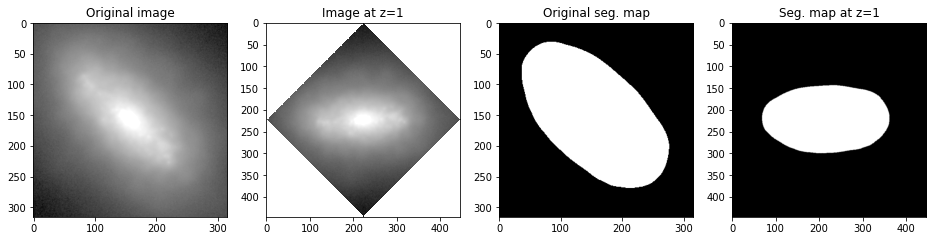

In [151]:
if EXAMPLE:
    
    img_rot, map_rot = rotate_galaxy(img, segmap, 45)
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(-2.5*np.log10(img),     cmap="gray_r",  vmin=20, vmax=30); axs[0].set_title("Original image")
    axs[1].imshow(-2.5*np.log10(img_rot), cmap="gray_r",  vmin=20, vmax=30); axs[1].set_title("Image at z=1")
    axs[2].imshow(segmap,                 cmap="gray"); axs[2].set_title("Original seg. map")
    axs[3].imshow(map_rot,                cmap="gray"); axs[3].set_title("Seg. map at z=1")

### Project to field

Place the galaxy image onto a larger field at position x, y.

**Note:** we project so that the galaxy image may be cut off - this is more realistic for real datasets if we take a random snapshot of a survey


In [152]:
def project_to_field(img, segmap, field_size, x, y):
    """Place the image to a position (x, y) in the larger field. Values outside the image are 0.
    INPUTS:
        img:         np.ndarray with galaxy iamge
        segmap:      integer np.ndarray with segmentation map
        field_size:  size of the larger (square) field image 
        x, y:        x, y coordinates of the image center
        
    OUTPUTS:
        newimg, newmap: image and segmentation map projected onto an image with the same size as the field.
    """
    
    newimg = np.zeros(shape=(field_size, field_size))
    newmap = np.zeros_like(newimg)
    
    # Figure our image size, and split into left/right if image is odd
    L         = img.shape[0]
    left      = int(L/2)
    right     = left if L%2 == 0 else left+1
    
    # If the image is outside field area, cut off the image so it fits
    xslice    = slice( np.max([0, left-x]) ,  L + np.min([0, field_size - (x+right)]))
    yslice    = slice( np.max([0, left-y]) ,  L + np.min([0, field_size - (y+right)]))
    imgxslice = slice( np.max([0, x-left]),   np.min([field_size, x+right]))
    imgyslice = slice( np.max([0, y-left]),   np.min([field_size, y+right]))
                                         
    newimg[imgyslice, imgxslice] = img[yslice, xslice]
    newmap[imgyslice, imgxslice] = segmap[yslice, xslice]
    
    return newimg, newmap

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


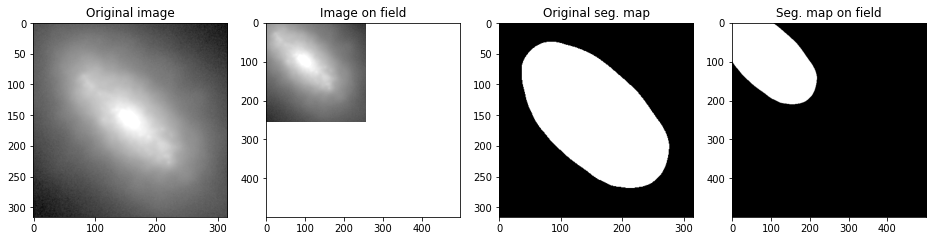

In [302]:
if EXAMPLE:
    
    field_size = 500
    img_field, map_field = project_to_field(img, segmap, field_size, 100, 100)
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(-2.5*np.log10(img),       cmap="gray_r",  vmin=20, vmax=30); axs[0].set_title("Original image")
    axs[1].imshow(-2.5*np.log10(img_field), cmap="gray_r",  vmin=20, vmax=30); axs[1].set_title("Image on field")
    axs[2].imshow(segmap,                   cmap="gray"); axs[2].set_title("Original seg. map")
    axs[3].imshow(map_field,                cmap="gray"); axs[3].set_title("Seg. map on field")

## Combine transformations

The order of transformations is:

1. Move to a redshift: `move_to_z`
2. Rotate: `rotate_galaxy` 
3. Place on the field: `project_to_field`

We randomly generate the redshift, angle and position on the field using the global variables defined above.

In [482]:
def random_transform_galaxy(img, segmap, field_size, lims, edgefrac=0.05):
    """Move a galaxy image to a larger redshift, rotate it, and palce onto a field-like plane. 
    Redshift, angle, and coordinates on the field are randomly generated as given in the limits dict.
    INPUTS:
        img:         np.ndarray with galaxy iamge
        segmap:      integer np.ndarray with segmentation map
        field_size:  size of the parent field image
        lims:        dictionary with RNG limits. Must have all entries used by this function
        edge_frac:   fraction of galaxy image that is an "edge" when checking if outer SB is low enough
    OUTPUTS:
        field_img, field_map: transformed image and segmentation map
    """
    
    # Check all RNG parameters are given in the limits dict
    req_limits = {"Z0",  "Z_MEAN",  "Z_SD", "BG_THRESHOLD", "GALAXIES_MUST_FIT"}
    assert req_limits.issubset(set(lims.keys())), "Make sure all RNG limits are in limits dict"

    # Move to a redshift
    z           = np.max([lims["Z0"], gauss.rvs(loc=lims["Z_MEAN"], scale=lims["Z_SD"], size=1)[0]])
    img, segmap = move_to_z(img, segmap,  z, lims["Z0"])
    
    # Check if the image is dim enough on its edges. If not, move on to the next one
    temp   = img.copy()
    edgepx = int(temp.shape[0] * edgefrac)         # Size of the edge where we check bg flux
    temp[edgepx:-edgepx, edgepx:-edgepx] = np.nan  # Set everything else to nan
    edge_avg    = -2.5*np.log10(np.nanmean(temp))  # Calculate mag/arcsec2 on the edge
    if edge_avg < lims["BG_THRESHOLD"]+0.5:        # If too bright, return None & try another galaxy 
        return None, None, None
    
    
    # Rotate
    angle       = 360*np.random.random()
    img, segmap = rotate_galaxy(img, segmap, angle)
    
    
    
    # Place on the field image
    L      = img.shape[0]
    left   = int(L/2)
    right  = left if L%2 == 0 else left+1
    if lims["GALAXIES_MUST_FIT"]: 
        xcent, ycent = np.random.randint(low=left, high=field_size-right, size=2)
    else:
        xcent, ycent = np.random.randint(low=int(-left/2+10), high=field_size+int(right/2)-10, size=2)
    field_img, field_segmap = project_to_field(img, segmap, field_size, xcent, ycent)
    
    
    return field_img, field_segmap, z
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


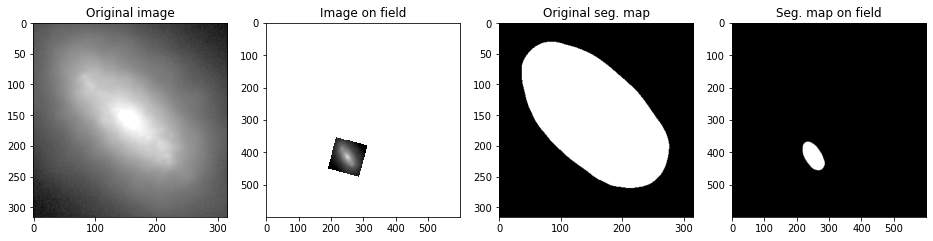

In [464]:
if EXAMPLE:
    
    img_field, map_field, z = random_transform_galaxy(img, segmap, field_size, RNG_LIMITS)
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(-2.5*np.log10(img),       cmap="gray_r",  vmin=20, vmax=30); axs[0].set_title("Original image")
    axs[1].imshow(-2.5*np.log10(img_field), cmap="gray_r",  vmin=20, vmax=30); axs[1].set_title("Image on field")
    axs[2].imshow(segmap,                   cmap="gray"); axs[2].set_title("Original seg. map")
    axs[3].imshow(map_field,                cmap="gray"); axs[3].set_title("Seg. map on field")

## Generate fields

In [465]:
sample = pd.DataFrame({"id" : [416531]})
sample

,id
0,416531


In [493]:
def make_field(sample_df, lims, progress=False):
    """Make a mock field image by stacking randomly sampled and transformed subhaloes. Segmentation maps are
    also stacked, with smaller haloes projected on top.
    INPUTS:
        sample_df:   indices of subhaloes that can be used in the field
        lims:        dictionary with RNG limits. Must have all entries used by this function
        progress:    whether to print out progress %
    OUTPUTS:
        field_img, field_map: transformed image and segmentation map
    """      


    # Check all RNG parameters are given in the limits dict
    req_limits = {"IMGSIZE_MIN", "IMGSIZE_MAX", "GAL_FRAC", "D_GAL_FRAC",
                  "Z0",  "Z_MEAN",  "Z_SD", "BG_THRESHOLD", "GALAXIES_MUST_FIT"}
    assert req_limits.issubset(set(lims.keys())), "Make sure all RNG limits are in limits dict"
        
    # Figure out the field size and number of galaxies
    field_size    = np.random.randint(low=lims["IMGSIZE_MIN"], high=lims["IMGSIZE_MAX"])
    frac_galaxies = lims["GAL_FRAC"] + lims["D_GAL_FRAC"]*(np.random.random()-0.5)
    ngalaxies     = int(frac_galaxies * field_size)
    
    # Set a constant background
    bgval = np.power(10, -lims["BG_THRESHOLD"]/2.5)
    field = gauss.rvs(loc=0, scale=bgval, size=(field_size, field_size))


    # Add galaxies until num_current is equal to ngalaxies
    # Save segmaps and redshifts to stack them later
    n_current   = 0
    segmaps       = []
    redshifts     = []
    while n_current <= ngalaxies:

        if progress: 
            print(n_current, end=" ")

        gal    = int(sample_df.sample(1).iloc[0]["id"])
        camera = np.random.randint(0, 4)
        file   = fits.open(f"{path}/subhaloes/{gal}_{camera}.fits")

        img     = file[0].data    
        segmap  = file[1].data
        file.close()
        
        field_img, field_segmap, z = random_transform_galaxy(img, segmap, field_size, lims)
        if field_img is None: continue

        n_current += 1
        field       += field_img
        segmaps.append(np.array(field_segmap, dtype=int))
        redshifts.append(z)

    # Stack segmaps on top of each other, with highest redshift last 
    # b/c it would be the smallest footprint
        
    indices     = np.argsort(redshifts)
    maps_sorted = np.array(segmaps)[indices]#[::-1]

    segmap      = np.zeros_like(field)
    for idx, segm in enumerate(maps_sorted):
        segmap[segm != 0] = (idx+1)
    
    return field, segmap

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 

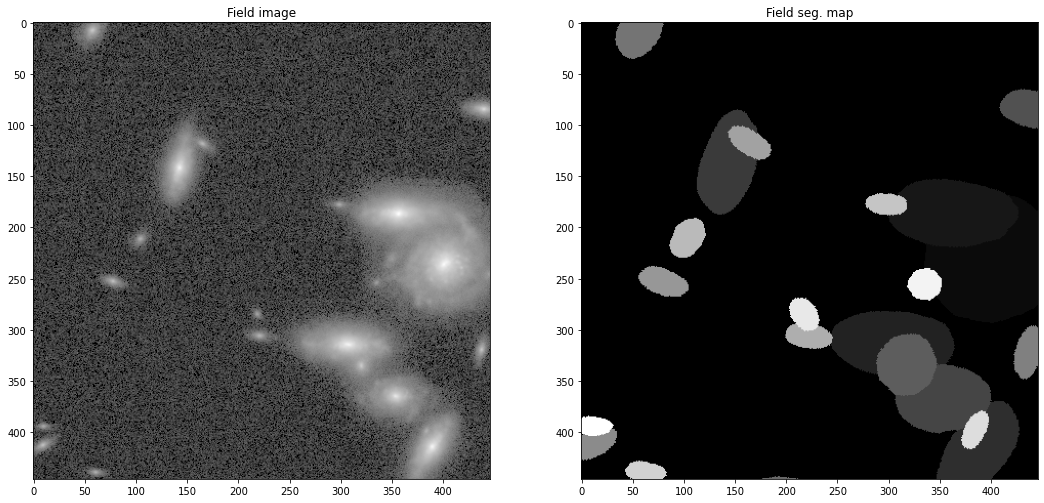

In [494]:
if EXAMPLE:
    
    field, segmaps = make_field(sample, RNG_LIMITS, progress=True)
    fig, axs = plt.subplots(1, 2, figsize=(18, 9))
    axs[0].imshow(-2.5*np.log10(np.abs(field)), cmap="gray_r",  vmin=20, vmax=30); axs[0].set_title("Field image")
    axs[1].imshow(segmaps,              cmap="gray"); axs[1].set_title("Field seg. map")